### Necessary Libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

### The constants

In [ ]:
# Define constants
BATCH_SIZE = 5
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
IMAGE_SIZE = (384, 512)
MEAN = [0.71839072, 0.71970842, 0.7157906]
STD = [0.229, 0.224, 0.225]
THRESHOLD = 0.6

# Define file paths
IMAGE_DIR = '/content/drive/My Drive/Mikroplastikai/S_2021_01'
MASK_DIR = '/content/drive/My Drive/Mikroplastikai/masks'
MODEL_PATH = 'microplastic_segmentation_model.pth'


### Microplastics Dataset

In [ ]:
# --------------------------
# Dataset Preparation
# --------------------------
class MicroplasticsDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_transforms=None, mask_transforms=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])

        if self.image_transforms:
            image = self.image_transforms(image)

        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        return image, mask

### Train and test datasets and data loader

In [ ]:
def get_data_loaders_and_datasets(train_images, test_images, train_masks, test_masks, batch_size):
    # Data transformations
    image_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    mask_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor()
    ])

    train_dataset = MicroplasticsDataset(train_images, train_masks, image_transforms=image_transform, mask_transforms=mask_transform)
    test_dataset = MicroplasticsDataset(test_images, test_masks, image_transforms=image_transform, mask_transforms=mask_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset

### Define the U-Net Model

In [ ]:
import torch
import torch.nn as nn

# The convolutional block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

# The UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_conv_1 = conv_block(3, 64)
        self.down_conv_2 = conv_block(64, 128)
        self.down_conv_3 = conv_block(128, 256)
        self.down_conv_4 = conv_block(256, 512)
        self.down_conv_5 = conv_block(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = conv_block(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = conv_block(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = conv_block(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = conv_block(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, image):
        # Downscaling part
        x1 = self.down_conv_1(image)
        x2 = self.down_conv_2(nn.MaxPool2d(kernel_size=2, stride=2)(x1))
        x3 = self.down_conv_3(nn.MaxPool2d(kernel_size=2, stride=2)(x2))
        x4 = self.down_conv_4(nn.MaxPool2d(kernel_size=2, stride=2)(x3))
        x5 = self.down_conv_5(nn.MaxPool2d(kernel_size=2, stride=2)(x4))

        # Upscaling part and skip connections
        x = self.up_trans_1(x5)
        x = self.up_conv_1(torch.cat([x, x4], 1))

        x = self.up_trans_2(x)
        x = self.up_conv_2(torch.cat([x, x3], 1))

        x = self.up_trans_3(x)
        x = self.up_conv_3(torch.cat([x, x2], 1))

        x = self.up_trans_4(x)
        x = self.up_conv_4(torch.cat([x, x1], 1))

        x = self.out(x)
        return x

model = UNet()

### Train the Model

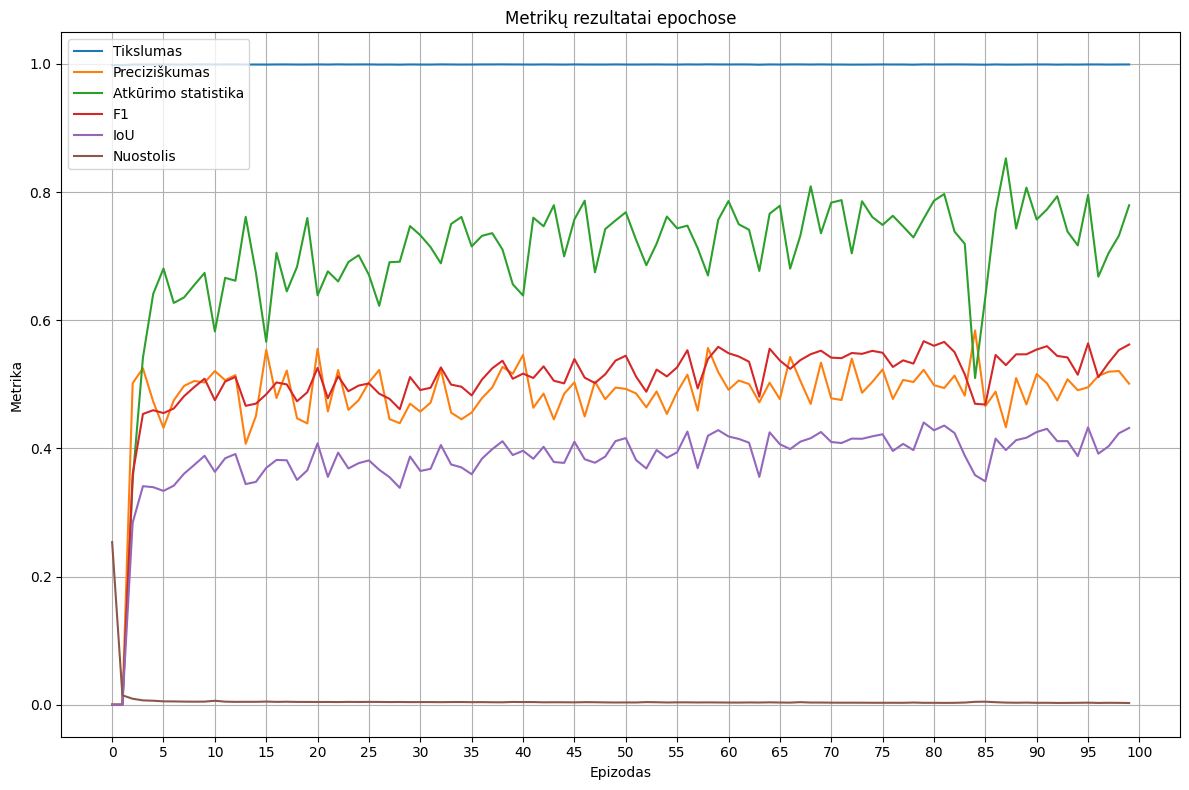

Epoch accuracies: [0.9980401561093428, 0.9980401561093428, 0.9989521670243375, 0.9990391358426568, 0.9989404874574008, 0.9989948037229939, 0.9989228425202547, 0.9989105350196117, 0.9991657900712128, 0.9991845024956597, 0.9991138599537037, 0.9991709391276044, 0.9991821791409465, 0.9989290590639468, 0.9990223072193288, 0.9989489017690654, 0.9991102179382072, 0.9991327607582627, 0.998962904690715, 0.9990120718999165, 0.9991904050724987, 0.9989723236963092, 0.9992358046794624, 0.9990461059067965, 0.9991398564091435, 0.9991728229287228, 0.9989234076605903, 0.9990030296545461, 0.9987843203446503, 0.9991243464465984, 0.9989732028034979, 0.9989512251237783, 0.9992088663234633, 0.9990704069412294, 0.998945699307163, 0.9990215536988813, 0.9991284280156892, 0.9991488986545138, 0.999218348122428, 0.9991132320199974, 0.9990386962890625, 0.998963595417792, 0.9991493382081083, 0.9990469850139854, 0.9989190121246464, 0.999138098194766, 0.9990009574733152, 0.9989885871793018, 0.9989688700609246, 0.9991

In [ ]:
# --------------------------
# Training the Model
# --------------------------
images = [os.path.join(IMAGE_DIR, x) for x in sorted(os.listdir(IMAGE_DIR))]
masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_loader, test_loader, train_dataset, test_dataset = get_data_loaders_and_datasets(train_images, test_images, train_masks, test_masks, BATCH_SIZE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

epoch_accuracy = []
epoch_precision = []
epoch_recall = []
epoch_f1 = []
epoch_iou = []
epoch_losses = []

def tensor_to_numpy_binary(tensor):
    return tensor.cpu().detach().numpy().astype(np.uint8)

def calculate_iou(predicted, target):
    intersection = np.logical_and(target, predicted)
    union = np.logical_or(target, predicted)
    if np.sum(union) == 0:
        iou_score = 0.0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    num_batches = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    epoch_losses.append(average_loss)

    # Evaluation phase
    model.eval()
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    iou_list = []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)
            predicted_mask = (predicted_probs > THRESHOLD).float()

            for j in range(images.size(0)):
                mask_np = tensor_to_numpy_binary(masks[j])
                predicted_mask_np = tensor_to_numpy_binary(predicted_mask[j])

                mask_np_flat = mask_np.flatten()
                predicted_mask_np_flat = predicted_mask_np.flatten()

                accuracy_list.append(accuracy_score(mask_np_flat, predicted_mask_np_flat))
                precision_list.append(precision_score(mask_np_flat, predicted_mask_np_flat, zero_division=0))
                recall_list.append(recall_score(mask_np_flat, predicted_mask_np_flat, zero_division=0))
                f1_list.append(f1_score(mask_np_flat, predicted_mask_np_flat, zero_division=0))
                iou_list.append(calculate_iou(predicted_mask_np, mask_np))

    epoch_accuracy.append(np.mean(accuracy_list))
    epoch_precision.append(np.mean(precision_list))
    epoch_recall.append(np.mean(recall_list))
    epoch_f1.append(np.mean(f1_list))
    epoch_iou.append(np.mean(iou_list))

epochs = range(0, NUM_EPOCHS)
def plot_metrics(epochs, accuracy, precision, recall, f1, iou, losses):
    plt.figure(figsize=(12, 8))

    # Metrics
    plt.plot(epochs, accuracy, label='Tikslumas')
    plt.plot(epochs, precision, label='Preciziškumas')
    plt.plot(epochs, recall, label='Atkūrimo statistika')
    plt.plot(epochs, f1, label='F1')
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, losses, label='Nuostolis')

    plt.xlabel('Epizodas')
    plt.ylabel('Metrika')
    plt.title('Metrikų rezultatai epochose')
    plt.legend(loc='upper left')
    plt.xticks(np.arange(0, NUM_EPOCHS + 1, 5))
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(epochs, epoch_accuracy, epoch_precision, epoch_recall, epoch_f1, epoch_iou, epoch_losses)

print(f'Epoch accuracies: {epoch_accuracy}')
print(f'Epoch precisions: {epoch_precision}')
print(f'Epoch recalls: {epoch_recall}')
print(f'Epoch F1 Scores: {epoch_f1}')
print(f'Epoch IoUs: {epoch_iou}')
print(f'Epoch losses: {epoch_losses}')

### Evaluation and Visualization

In [ ]:
# --------------------------
# Evaluation and Visualization
# --------------------------
import numpy as np

# Function to convert the output tensor to numpy array and binary format
def tensor_to_numpy_binary(tensor):
    return tensor.cpu().detach().numpy().astype(np.uint8)

def calculate_iou(predicted, target):
    intersection = np.logical_and(target, predicted)
    union = np.logical_or(target, predicted)
    if np.sum(union) == 0:
        iou_score = 0.0
    else:
        iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
iou_list = []

# Evaluate the model and visualize the results
model.eval()
with torch.no_grad():
    image_counter = 0

    for i, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for j in range(images.size(0)):
            image_counter += 1

            # Apply sigmoid to get probabilities and then threshold to get binary output
            predicted_probs = torch.sigmoid(outputs[j])
            predicted_mask = (predicted_probs > THRESHOLD).float()

            # Convert the tensors to binary format for metric calculation
            mask_np = tensor_to_numpy_binary(masks[j])
            predicted_mask_np = tensor_to_numpy_binary(predicted_mask)

            # Flatten the arrays for metric calculations
            mask_np_flat = mask_np.flatten()
            predicted_mask_np_flat = predicted_mask_np.flatten()

            # Calculate metrics for each image and append to the lists
            accuracy_list.append(accuracy_score(mask_np_flat, predicted_mask_np_flat))
            precision_list.append(precision_score(mask_np_flat, predicted_mask_np_flat, zero_division=0))
            recall_list.append(recall_score(mask_np_flat, predicted_mask_np_flat, zero_division=0))
            f1_list.append(f1_score(mask_np_flat, predicted_mask_np_flat, zero_division=0))

            iou_score = calculate_iou(predicted_mask_np, mask_np)
            iou_list.append(iou_score)

            # Visualization - Display the first set of original, normalized, mask, and predicted mask images
            plt.figure(figsize=(15, 5))

            # Original Image (without normalization)
            original_image_path = test_dataset.image_paths[i * test_loader.batch_size + j]
            original_image = Image.open(original_image_path)
            plt.subplot(1, 3, 1)
            plt.imshow(original_image)
            plt.title(f'Orginali Nuotrauka {image_counter}')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[j].cpu().squeeze(), cmap='gray')
            plt.title(f'Tikrasis Užmaskavimas {image_counter}')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask.cpu().squeeze(), cmap='gray')
            plt.title(f'Užmaskavimo Prognozė {image_counter}')
            plt.axis('off')

            plt.show()

# Calculate and print average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_iou = np.mean(iou_list)

print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}')
print(f'Average IoU: {avg_iou:.4f}')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(model.state_dict(), 'microplastic_segmentation_model.pth')